<h1><center>ICT for Smart Mobility</center></h1>

<center><font size="5">Exercise – Transport modelling </font></center>
<center><font size="5">Creating trip generation and trip distribution model of demand </font></center>



In [2]:
import pandas as pd
df=pd.read_csv("Amsterdam_dataset.csv")

In [3]:
df

Unnamed: 0  start_longitude  start_latitude  end_longitude  \
0           7860          4.87345        52.33396        4.82726   
1           7872          4.90472        52.37038        4.91088   
2           7887          4.92591        52.36526        4.92612   
3           7854          4.87818        52.39087        4.88443   
4           7861          4.93046        52.33535        4.90276   
...          ...              ...             ...            ...   
3649      575334          4.88705        52.36311        4.84528   
3650      575332          4.86997        52.36838        4.85935   
3651      575343          4.88375        52.36534        4.93667   
3652      575329          4.84560        52.38111        4.86470   
3653      575336          4.94624        52.35168        4.88473   

      end_latitude  start_longitude_utm  start_latitude_utm  \
0         52.35371        119982.797780       483016.349361   
1         52.34494        122141.094886       487053.891014   
2         52.35110        123580.569820       486474.827223   
3         52.37641        120349.660072       489346.036596   
4         52.35757        123869.504307       483144.993367   
...            ...                  ...                 ...   
3649      52.38648        120932.135664       486253.167987   
3650      52.36600        119772.934718       486847.688238   
3651      52.37119        120709.083198       486502.840335   
3652      52.36538        118123.783770       488276.187663   
3653      52.33589        124956.071340       484955.255267   

      end_longitude_utm  end_latitude_utm  hour  daytype  
0         116851.530361     485237.087955    23  weekday  
1         122542.006910     484220.588956    23  weekday  
2         123584.850648     484899.252532    23  weekday  
3         120763.943156     487734.199761    23  weekday  
4         121998.086446     485629.503238    23  weekday  
...                 ...               ...   ...      ...  
3649      118106.464532     488873.832576    23  weekday  
3650      119047.722853     486588.098133    23  weekday  
3651      124317.543982     487130.008302    23  weekday  
3652      119411.610806     486516.474729    23  weekday  
3653      120753.116164     483225.696241    23  weekday  

[3654 rows x 11 columns]

## STEP A - Zoning

Explore the sample locations in the dataset

In [4]:
import geopandas as gpd
from geopandas import GeoDataFrame

# starting points --> origins 
geometry = gpd.points_from_xy(df["start_longitude"],df["start_latitude"],crs="EPSG:4326")
gdf = GeoDataFrame(df, geometry=geometry)   
gdf.explore()

In [5]:
# ending points --> destinations
geometry = gpd.points_from_xy(df["end_longitude"],df["end_latitude"],crs="EPSG:4326")
gdf = GeoDataFrame(df, geometry=geometry)   
gdf.explore()

Propose a zoning system of zones z in Z

In [6]:
#Here I am finding the min logitude, max longitude, min latitude and max latitude observed as origin/destination
import numpy as np
import math

min_lon=min(df["start_longitude"].min(),df["end_longitude"].min())
max_lon=max(df["start_longitude"].max(),df["end_longitude"].max())
min_lat=min(df["start_latitude"].min(),df["end_latitude"].min())
max_lat=max(df["start_latitude"].max(),df["end_latitude"].max())

In [7]:
#Then, I am defining four points that corresponds to the vertices of the (smallest) large rectangular area containing all the trips 
bottomLeft = (min_lat, min_lon)
bottomRight = (min_lat, max_lon)
topLeft = (max_lat, min_lon)
topRight = (max_lat, max_lon)

In [8]:
print(bottomLeft)
print(bottomRight)
print(topLeft)
print(topRight)

(np.float64(52.3025), np.float64(4.8178))
(np.float64(52.3025), np.float64(5.01351))
(np.float64(52.41481), np.float64(4.8178))
(np.float64(52.41481), np.float64(5.01351))


In [9]:
#For simplicity, I am defining the total number of zones in my zoning systems and then I will divide the previous rectangular area into 
#smaller rectangles -> same number dividing latitude and same number dividing longitude

Number_zones_total=25

x=int(math.sqrt(Number_zones_total))+1  #these are the number of points dividing the range for coordinates (lat and long)
cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x) #these are the indexes for longitude 
rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x) #these are the indexes for latitude 

In [10]:
cols

array([4.81779 , 4.856936, 4.896082, 4.935228, 4.974374, 5.01352 ])

In [11]:
rows

array([52.30249 , 52.324956, 52.347422, 52.369888, 52.392354, 52.41482 ])

In [12]:
#Now I can assign each trip in df to its zone. One row+col for the start (origin) and one row+col for the end (destination)

df['col_start'] = np.searchsorted(cols, df["start_longitude"])
df['row_start'] = np.searchsorted(rows, df["start_latitude"])

df['col_end'] = np.searchsorted(cols, df["end_longitude"])
df['row_end'] = np.searchsorted(rows, df["end_latitude"])


In [13]:
# I am also creating a single id for each zone by concatenating row and column. Example: row 1 and column 2 --> zone_id = "12"

df["zone_id_start"] = df["row_start"].astype(str) + df["col_start"].astype(str)
df["zone_id_end"] = df["row_end"].astype(str) + df["col_end"].astype(str)

NOTE: In the previous code I am not properly creating square zones. indeed, the sides of the zones I created might be different considering latitude and longitude. To properly create square zones, use coordinates translated into meters, and then define a side lenght in place of the number of zones.

## STEP B – Trip generation

Given the zoning system Z, propose a trip generation model:

    • Estimate the probability of origins P(O) and destinations P(D) 
    • The calibrated model from the samples is the one that assign to P(O) the fraction of observed trips starting from O

In [14]:
# First, we count how many trips are starting from each zone
res_origin=df.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
#Then, we count the total number of trips
sum_origin=res_origin["count"].sum()
#The proabability is estimated as the fraction of trips
res_origin["prob_origin"]=res_origin["count"]/sum_origin
res_origin=res_origin.rename(columns={"count": "count_origin"})
res_origin

row_start  col_start zone_id_start  count_origin  prob_origin
0           1          2            12            25     0.006842
1           1          4            14            86     0.023536
2           2          1            21            28     0.007663
3           2          2            22           173     0.047345
4           2          3            23           120     0.032841
5           2          4            24            14     0.003831
6           2          5            25             1     0.000274
7           3          1            31           210     0.057471
8           3          2            32           858     0.234811
9           3          3            33           666     0.182266
10          3          4            34           115     0.031472
11          3          5            35            49     0.013410
12          4          1            41           221     0.060482
13          4          2            42           682     0.186645
14          4          3            43           262     0.071702
15          4          4            44            38     0.010400
16          5          2            52            49     0.013410
17          5          3            53            42     0.011494
18          5          4            54            15     0.004105

In [15]:
#Now repeat everything for destinations
res_dest=df.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
sum_destination=res_dest["count"].sum()
res_dest["prob_destination"]=res_dest["count"]/sum_destination
res_dest=res_dest.rename(columns={"count": "count_destination"})
res_dest

row_end  col_end zone_id_end  count_destination  prob_destination
0         1        2          12                 32          0.008758
1         1        4          14                209          0.057198
2         2        1          21                 52          0.014231
3         2        2          22                209          0.057198
4         2        3          23                178          0.048714
5         2        4          24                 28          0.007663
6         2        5          25                  1          0.000274
7         3        1          31                380          0.103996
8         3        2          32                492          0.134647
9         3        3          33                481          0.131637
10        3        4          34                160          0.043788
11        3        5          35                206          0.056377
12        4        1          41                301          0.082375
13        4        2          42                428          0.117132
14        4        3          43                146          0.039956
15        4        4          44                107          0.029283
16        5        2          52                 43          0.011768
17        5        3          53                147          0.040230
18        5        4          54                 54          0.014778

In [16]:
#merge the two previous dataframes
trip_generation=res_dest.merge(res_origin[["count_origin", "prob_origin","zone_id_start"]], left_on='zone_id_end', right_on='zone_id_start').reset_index()
trip_generation=trip_generation.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
trip_generation

index  row  col zone_id  count_destination  prob_destination  \
0       0    1    2      12                 32          0.008758   
1       1    1    4      14                209          0.057198   
2       2    2    1      21                 52          0.014231   
3       3    2    2      22                209          0.057198   
4       4    2    3      23                178          0.048714   
5       5    2    4      24                 28          0.007663   
6       6    2    5      25                  1          0.000274   
7       7    3    1      31                380          0.103996   
8       8    3    2      32                492          0.134647   
9       9    3    3      33                481          0.131637   
10     10    3    4      34                160          0.043788   
11     11    3    5      35                206          0.056377   
12     12    4    1      41                301          0.082375   
13     13    4    2      42                428          0.117132   
14     14    4    3      43                146          0.039956   
15     15    4    4      44                107          0.029283   
16     16    5    2      52                 43          0.011768   
17     17    5    3      53                147          0.040230   
18     18    5    4      54                 54          0.014778   

    count_origin  prob_origin zone_id_start  
0             25     0.006842            12  
1             86     0.023536            14  
2             28     0.007663            21  
3            173     0.047345            22  
4            120     0.032841            23  
5             14     0.003831            24  
6              1     0.000274            25  
7            210     0.057471            31  
8            858     0.234811            32  
9            666     0.182266            33  
10           115     0.031472            34  
11            49     0.013410            35  
12           221     0.060482            41  
13           682     0.186645            42  
14           262     0.071702            43  
15            38     0.010400            44  
16            49     0.013410            52  
17            42     0.011494            53  
18            15     0.004105            54

    ◦ Evaluate the total log likelihood metric to be maximized: 1/N sum_(samples s) log(P(s))

In [17]:
# We need to associate to each trip in the dataset the probability of its zone
df_prob=df.merge(trip_generation[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
              .merge(trip_generation[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')
df_prob

Unnamed: 0  start_longitude  start_latitude  end_longitude  \
0           7860          4.87345        52.33396        4.82726   
1           7872          4.90472        52.37038        4.91088   
2           7887          4.92591        52.36526        4.92612   
3           7854          4.87818        52.39087        4.88443   
4           7861          4.93046        52.33535        4.90276   
...          ...              ...             ...            ...   
3649      575334          4.88705        52.36311        4.84528   
3650      575332          4.86997        52.36838        4.85935   
3651      575343          4.88375        52.36534        4.93667   
3652      575329          4.84560        52.38111        4.86470   
3653      575336          4.94624        52.35168        4.88473   

      end_latitude  start_longitude_utm  start_latitude_utm  \
0         52.35371        119982.797780       483016.349361   
1         52.34494        122141.094886       487053.891014   
2         52.35110        123580.569820       486474.827223   
3         52.37641        120349.660072       489346.036596   
4         52.35757        123869.504307       483144.993367   
...            ...                  ...                 ...   
3649      52.38648        120932.135664       486253.167987   
3650      52.36600        119772.934718       486847.688238   
3651      52.37119        120709.083198       486502.840335   
3652      52.36538        118123.783770       488276.187663   
3653      52.33589        124956.071340       484955.255267   

      end_longitude_utm  end_latitude_utm  hour  ... col_start  row_start  \
0         116851.530361     485237.087955    23  ...         2          2   
1         122542.006910     484220.588956    23  ...         3          4   
2         123584.850648     484899.252532    23  ...         3          3   
3         120763.943156     487734.199761    23  ...         2          4   
4         121998.086446     485629.503238    23  ...         3          2   
...                 ...               ...   ...  ...       ...        ...   
3649      118106.464532     488873.832576    23  ...         2          3   
3650      119047.722853     486588.098133    23  ...         2          3   
3651      124317.543982     487130.008302    23  ...         2          3   
3652      119411.610806     486516.474729    23  ...         1          4   
3653      120753.116164     483225.696241    23  ...         4          3   

      col_end  row_end  zone_id_start zone_id_end prob_destination  zone_id_x  \
0           1        3             22          31         0.103996         31   
1           3        2             43          23         0.048714         23   
2           3        3             33          33         0.131637         33   
3           2        4             42          42         0.117132         42   
4           3        3             23          33         0.131637         33   
...       ...      ...            ...         ...              ...        ...   
3649        1        4             32          41         0.082375         41   
3650        2        3             32          32         0.134647         32   
3651        4        4             32          44         0.029283         44   
3652        2        3             41          32         0.134647         32   
3653        2        2             34          22         0.057198         22   

     prob_origin  zone_id_y  
0       0.047345         22  
1       0.071702         43  
2       0.182266         33  
3       0.186645         42  
4       0.032841         23  
...          ...        ...  
3649    0.234811         32  
3650    0.234811         32  
3651    0.234811         32  
3652    0.060482         41  
3653    0.031472         34  

[3654 rows x 21 columns]

In [18]:
#Now we can compute the loglikelihood of the samples
#origin
logLikelihoodOrigin=1/len(df_prob)*sum(np.log(df_prob["prob_origin"]))
logLikelihoodOrigin                      

-2.2723019446355575

In [19]:
#Now we can compute the loglikelihood of the samples
#destinatin
logLikelihoodDestination=1/len(df_prob)*sum(np.log(df_prob["prob_destination"]))
logLikelihoodDestination

-2.620196044630355

    • Show the distributions P(O) and P(D) of the trip generation model on a map

We show it with geopandas. We need to create for each zone, the polygon representing the side of the rectangles


In [20]:
# We define for each zone, the minimum latitude and longitude and the maximum latitude and longitude
trip_generation["lon_min"]=cols[trip_generation["col"]-1]
trip_generation["lon_max"]=cols[trip_generation["col"]]
trip_generation["lat_min"]=rows[trip_generation["row"]-1]
trip_generation["lat_max"]=rows[trip_generation["row"]]

In [21]:
from shapely.geometry import Point, Polygon

#Now we create the four vertices for each zone
trip_generation['A'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_generation['B'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_generation['C'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_generation['D'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

#finally, we create the polygon (rectangle) with its four vertices
trip_generation['geometry']=trip_generation.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)

In [22]:
#We show the zones with their probability of origin
gdf_gen = GeoDataFrame(trip_generation["prob_origin"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_origin',tooltip='prob_origin')

In [23]:
#We show the zones with their probability of destination
gdf_dest = GeoDataFrame(trip_generation["prob_destination"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_dest.explore(column='prob_destination',tooltip='prob_destination')

## STEP C – Trip generation validation
Now observe the performance of the created model on ‘new’ data. Indeed, the model might overfit the observed sample.

    • Divide the sample dataset into random training (2/3) and validation (1/3) samples


In [24]:
from sklearn.model_selection import train_test_split

In [25]:
df_train, df_validation = train_test_split(df, test_size=0.33, shuffle=True)

    • Now go back to STEP B and recompute the trip generation on the training
   

In [26]:
# we repeat the same code as in step B, but here on df_train instead of df
#origin
res_origin_train=df_train.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
sum_origin_train=res_origin_train["count"].sum()
res_origin_train["prob_origin"]=res_origin_train["count"]/sum_origin_train
res_origin_train=res_origin_train.rename(columns={"count": "count_origin"})
res_origin_train

row_start  col_start zone_id_start  count_origin  prob_origin
0           1          2            12            18     0.007353
1           1          4            14            53     0.021650
2           2          1            21            18     0.007353
3           2          2            22           109     0.044526
4           2          3            23            79     0.032271
5           2          4            24             8     0.003268
6           3          1            31           132     0.053922
7           3          2            32           571     0.233252
8           3          3            33           458     0.187092
9           3          4            34            68     0.027778
10          3          5            35            33     0.013480
11          4          1            41           150     0.061275
12          4          2            42           463     0.189134
13          4          3            43           186     0.075980
14          4          4            44            30     0.012255
15          5          2            52            37     0.015114
16          5          3            53            28     0.011438
17          5          4            54             7     0.002859

In [27]:
# we repeat the same code as in step B, but here on df_train instead of df
#destination
res_dest_train=df_train.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
sum_destination_train=res_dest_train["count"].sum()
res_dest_train["prob_destination"]=res_dest_train["count"]/sum_destination_train
res_dest_train=res_dest_train.rename(columns={"count": "count_destination"})
res_dest_train

row_end  col_end zone_id_end  count_destination  prob_destination
0         1        2          12                 28          0.011438
1         1        4          14                142          0.058007
2         2        1          21                 32          0.013072
3         2        2          22                142          0.058007
4         2        3          23                130          0.053105
5         2        4          24                 16          0.006536
6         2        5          25                  1          0.000408
7         3        1          31                249          0.101716
8         3        2          32                312          0.127451
9         3        3          33                322          0.131536
10        3        4          34                107          0.043709
11        3        5          35                134          0.054739
12        4        1          41                207          0.084559
13        4        2          42                291          0.118873
14        4        3          43                 97          0.039624
15        4        4          44                 76          0.031046
16        5        2          52                 26          0.010621
17        5        3          53                 96          0.039216
18        5        4          54                 40          0.016340

In [28]:
#as previously, merging the origin and destination dataframe
trip_generation_train=res_dest_train.set_index('zone_id_end').join(res_origin_train[["count_origin", "prob_origin","zone_id_start"]].set_index('zone_id_start')).reset_index()
trip_generation_train=trip_generation_train.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
trip_generation_train

zone_id  row  col  count_destination  prob_destination  count_origin  \
0       12    1    2                 28          0.011438          18.0   
1       14    1    4                142          0.058007          53.0   
2       21    2    1                 32          0.013072          18.0   
3       22    2    2                142          0.058007         109.0   
4       23    2    3                130          0.053105          79.0   
5       24    2    4                 16          0.006536           8.0   
6       25    2    5                  1          0.000408           NaN   
7       31    3    1                249          0.101716         132.0   
8       32    3    2                312          0.127451         571.0   
9       33    3    3                322          0.131536         458.0   
10      34    3    4                107          0.043709          68.0   
11      35    3    5                134          0.054739          33.0   
12      41    4    1                207          0.084559         150.0   
13      42    4    2                291          0.118873         463.0   
14      43    4    3                 97          0.039624         186.0   
15      44    4    4                 76          0.031046          30.0   
16      52    5    2                 26          0.010621          37.0   
17      53    5    3                 96          0.039216          28.0   
18      54    5    4                 40          0.016340           7.0   

    prob_origin  
0      0.007353  
1      0.021650  
2      0.007353  
3      0.044526  
4      0.032271  
5      0.003268  
6           NaN  
7      0.053922  
8      0.233252  
9      0.187092  
10     0.027778  
11     0.013480  
12     0.061275  
13     0.189134  
14     0.075980  
15     0.012255  
16     0.015114  
17     0.011438  
18     0.002859

 
 • Evaluate the total log likelihood of the training and validation. Which one is worse? Why?
 

In [29]:
# We need to associate to each trip in the TRAINING dataset the proability of its zone
df_prob_train=df_train.merge(trip_generation_train[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
           .merge(trip_generation_train[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')

In [30]:
#Now we can compute the loglikelihood of the TRAINING samples
#origin
logLikelihoodOrigin_train=1/len(df_prob_train)*sum(np.log(df_prob_train["prob_origin"]))
logLikelihoodOrigin_train                      

-2.2585499598673078

In [31]:
#Now we can compute the loglikelihood of the TRAINING samples
#destination
logLikelihoodDestination_train=1/len(df_prob_train)*sum(np.log(df_prob_train["prob_destination"]))
logLikelihoodDestination_train

-2.6280640971149833

To compute the loglikelihood of the validation samples, we need to associate to them the probability obtained from training 

Notice that in the VALIDATION we might have samples in a OD for which we do not have a TRAINING sample and therefore probability is 0

The logarithm of 0 is minus infinity: the model is therefore performing very bad on the validation. To avoid these cases, we can associate a small 'background' probability to all OD 

In this case we will take the minimum observed probability and dividing it by the total number of possible OD in the zoning system

REMARK: by replacing zones with probability with a small value, the obtained distribution is not properly a probability, since it will not sum anymore to one. To maintain a probability function, the distribution should be normalized again (not done here in the example)

In [32]:
#merge the VALIDATAION sample with the probability of origin and destination computed from the TRAINING
#'left' merge since we want to maintain even the samples without a probability (i.e., 0)
df_prob_validation=df_validation.merge(trip_generation_train[["prob_destination","zone_id"]],how='left', left_on='zone_id_end', right_on='zone_id')\
           .merge(trip_generation_train[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')

min_origin_p=min(trip_generation_train["prob_destination"])
min_destination_p=min(trip_generation_train["prob_origin"])

df_prob_validation["prob_destination"]=df_prob_validation["prob_destination"].replace(np.nan, min_destination_p/Number_zones_total) #replace nan (0) with a small background probability
df_prob_validation["prob_origin"]=df_prob_validation["prob_origin"].replace(np.nan, min_origin_p/Number_zones_total) #replace nan (0) with a small background probability

In [33]:
df_prob_validation

Unnamed: 0  start_longitude  start_latitude  end_longitude  \
0         320460          4.90224        52.37293        4.82887   
1          53410          4.92664        52.36664        5.00293   
2          14412          4.87524        52.36349        4.86385   
3         362095          4.90301        52.37542        4.91614   
4         355615          4.87087        52.36629        4.93736   
...          ...              ...             ...            ...   
1201      400972          4.90614        52.36847        4.88716   
1202      306156          4.88961        52.36982        4.95926   
1203      447656          4.87419        52.36257        4.84426   
1204      266469          4.88441        52.37645        4.87332   
1205       12175          4.94371        52.36156        4.85646   

      end_latitude  start_longitude_utm  start_latitude_utm  \
0         52.35256        121974.098362       487338.739231   
1         52.35282        123631.266436       486628.054160   
2         52.37162        120128.008840       486301.064716   
3         52.35777        122028.385543       487615.433907   
4         52.36375        119832.573194       486614.711953   
...            ...                  ...                 ...   
1201      52.35644        122236.390353       486840.735659   
1202      52.31920        121111.633239       486998.541771   
1203      52.34391        120055.765293       486199.208757   
1204      52.36771        120762.612164       487738.659733   
1205      52.35430        124790.424112       486055.585895   

      end_longitude_utm  end_latitude_utm  hour  ... col_start  row_start  \
0         116960.230936     485108.290320    23  ...         3          4   
1         128819.139360     485060.109415    23  ...         3          3   
2         119358.730721     487211.172007    23  ...         2          3   
3         122909.710948     485645.747742    23  ...         3          4   
4         124359.396252     486301.917796    23  ...         2          3   
...                 ...               ...   ...  ...       ...        ...   
1201      120934.508064     485510.993881    23  ...         3          3   
1202      125821.814170     481336.126320    23  ...         2          3   
1203      118001.540997     484137.906897    23  ...         2          3   
1204      120000.560530     486771.519093    23  ...         2          4   
1205      118841.353781     485287.764419    23  ...         4          3   

      col_end  row_end  zone_id_start zone_id_end prob_destination  zone_id_x  \
0           1        3             43          31         0.101716         31   
1           5        3             33          35         0.054739         35   
2           2        4             32          42         0.118873         42   
3           3        3             43          33         0.131536         33   
4           4        3             32          34         0.043709         34   
...       ...      ...            ...         ...              ...        ...   
1201        2        3             33          32         0.127451         32   
1202        4        1             32          14         0.058007         14   
1203        1        2             32          21         0.013072         21   
1204        2        3             42          32         0.127451         32   
1205        1        3             34          31         0.101716         31   

     prob_origin  zone_id_y  
0       0.075980         43  
1       0.187092         33  
2       0.233252         32  
3       0.075980         43  
4       0.233252         32  
...          ...        ...  
1201    0.187092         33  
1202    0.233252         32  
1203    0.233252         32  
1204    0.189134         42  
1205    0.027778         34  

[1206 rows x 21 columns]

In [34]:
#Now we can compute the loglikelihood of the VALIDATION samples
#destination
logLikelihodOrigin_validation=1/len(df_prob_validation)*sum(np.log(df_prob_validation["prob_origin"]))
logLikelihodOrigin_validation 

-2.305639250851265

In [35]:
#Now we can compute the loglikelihood of the VALIDATION samples
#origin
logLikelihodDestination_validation=1/len(df_prob_validation)*sum(np.log(df_prob_validation["prob_destination"]))
logLikelihodDestination_validation

-2.6078606321521987

    • Now go back to STEP A: what happens if you change the zone size? If you choose many zones, can you trust these data? 


To perform the operation, I copied all the previous code inside a for (from zone definition to loglikelihood computation), by changing each time the number of zones and saving the obtained loglikelihood

In [36]:
#define a list of zone sizes (square of integer number)
Number_zones_total_list=[4,9,16,25,36,49,64,81,100,225,400,529]

#define lists to save results of loglikelihood
logLikelihoodOrigin_train_list=[]
logLikelihoodDestination_train_list=[]
logLikelihoodOrigin_validation_list=[]
logLikelihoodDestination_validation_list=[]


for Number_zones_total in Number_zones_total_list:

    #all the following code has been copied from previous steps
    
    x=int(math.sqrt(Number_zones_total))+1

    cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x)
    rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x)
    df['col_start'] = np.searchsorted(cols, df["start_longitude"])
    df['row_start'] = np.searchsorted(rows, df["start_latitude"])
    df['col_end'] = np.searchsorted(cols, df["end_longitude"])
    df['row_end'] = np.searchsorted(rows, df["end_latitude"])

    df["zone_id_start"] = df["row_start"].astype(str) + df["col_start"].astype(str)
    df["zone_id_end"] = df["row_end"].astype(str) + df["col_end"].astype(str)

    df_train, df_validation = train_test_split(df, test_size=0.33, shuffle=True)
    
    res_origin_train=df_train.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
    sum_origin_train=res_origin_train["count"].sum()
    res_origin_train["prob_origin"]=res_origin_train["count"]/sum_origin_train
    res_origin_train=res_origin_train.rename(columns={"count": "count_origin"})

    res_dest_train=df_train.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
    sum_destination_train=res_dest_train["count"].sum()
    res_dest_train["prob_destination"]=res_dest_train["count"]/sum_destination_train
    res_dest_train=res_dest_train.rename(columns={"count": "count_destination"})

    trip_generation_train=res_dest_train.merge(res_origin_train[["count_origin", "prob_origin","zone_id_start"]], left_on='zone_id_end', right_on='zone_id_start').reset_index()
    trip_generation_train=trip_generation_train.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
    
    df_prob_train=df_train.merge(trip_generation_train[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
           .merge(trip_generation_train[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')
    
    df_prob_validation=df_validation.merge(trip_generation_train[["prob_destination","zone_id"]],how='left', left_on='zone_id_end', right_on='zone_id')\
               .merge(trip_generation_train[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')

    min_origin_p=min(trip_generation_train["prob_destination"])
    min_destination_p=min(trip_generation_train["prob_origin"])

    df_prob_validation["prob_destination"]=df_prob_validation["prob_destination"].replace(np.nan, min_destination_p/Number_zones_total) #replace nan (0) with a small background probability
    df_prob_validation["prob_origin"]=df_prob_validation["prob_origin"].replace(np.nan, min_origin_p/Number_zones_total) #replace nan (0) with a small background probability

    #saving the obtained loglikelihood
    logLikelihoodOrigin_train_list.append(1/len(df_prob_train)*sum(np.log(df_prob_train["prob_origin"])))
    logLikelihoodDestination_train_list.append(1/len(df_prob_train)*sum(np.log(df_prob_train["prob_destination"])))
    logLikelihoodOrigin_validation_list.append(1/len(df_prob_validation)*sum(np.log(df_prob_validation["prob_origin"])))
    logLikelihoodDestination_validation_list.append(1/len(df_prob_validation)*sum(np.log(df_prob_validation["prob_destination"])))


    • Plot the total log likelihood for training and validation data with respect to square size of zoning system. What is a good trade-off for zoning in your opinion?


In [37]:
print(logLikelihoodOrigin_train_list)
print(logLikelihoodDestination_train_list)
print(logLikelihoodOrigin_validation_list)
print(logLikelihoodDestination_validation_list)

[-1.1423615303347197, -1.4536138936884921, -1.943527132644502, -2.2566448096848983, -2.573856224757286, -2.8518132772669884, -3.0638502891623065, -3.2780463722417506, -3.4429551086659984, -4.081949089072324, -4.578133790647201, -4.810364516131294]
[-1.31900542637296, -1.7381215794916907, -2.3233167651954414, -2.621648148099006, -2.872261368094372, -3.2170071877271105, -3.4081354962794914, -3.5950849596776946, -3.758978751781909, -4.352335010353611, -4.836845767317281, -5.040936700516568]
[-1.143858833466404, -1.5131857803716644, -1.9619593007745488, -2.3013539920103083, -2.548819898761573, -2.859079474231473, -3.113701263701968, -3.2835080198019275, -3.4349128154885555, -4.133314238800588, -4.68298546739309, -4.884664675392467]
[-1.3147761366491353, -1.7329892008211483, -2.3336414565453993, -2.61827091681746, -2.9028951916970818, -3.2536793894400486, -3.4473741571723115, -3.6307332738400806, -3.837656854184527, -4.403831052478615, -4.987710274036794, -5.2594727419050695]


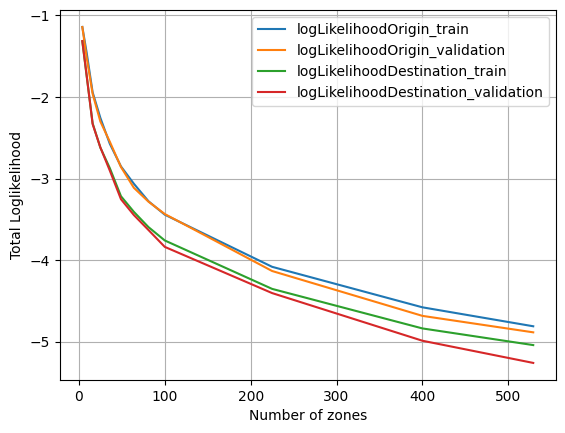

In [38]:
import matplotlib.pyplot as plt
plt.plot(Number_zones_total_list,logLikelihoodOrigin_train_list, label='logLikelihoodOrigin_train' )
plt.plot(Number_zones_total_list,logLikelihoodOrigin_validation_list, label='logLikelihoodOrigin_validation')
plt.plot(Number_zones_total_list,logLikelihoodDestination_train_list, label='logLikelihoodDestination_train')
plt.plot(Number_zones_total_list,logLikelihoodDestination_validation_list, label='logLikelihoodDestination_validation')
plt.xlabel("Number of zones")
plt.ylabel("Total Loglikelihood")
plt.legend()
plt.grid()
plt.show()

Train likelihood is always better than validation likelihood, since the model is calibrated on it. We are aveluating how the train based probabilities behaves with new trips (validation set). If the zoning is too detailed (many zones), we can have overfitting: the model is very good on training, but very bad on validation. A good trade-off is to have a zoning that is not too detailed, to avoid overfitting, but that is able to capture the main mobility patterns of the area.

Moreover, having less zones means to have more trips per zone and so the probabilities are more reliable (less affected by random noise). 
In this case, when we have too many zones we have many zones with no trips at all in training, so when we evaluate validation samples with origin or destination in these zones we have to assign a small probability, penalizing the loglikelihood.

## STEP D – Trip distribution

Given the zoning system Z, propose a trip distribution model:

    • Estimate the full OD matrix. i.e. the probability of moving from one origin O to a destination D: P(O,D)
    • The calibrated model from the samples is the one that assign to P(O,D) the fraction of observed trips starting from O and going to D



In [39]:
#First part is the zoning system. Same code as in step A

Number_zones_total=25


x=int(math.sqrt(Number_zones_total))+1

cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x)
rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x)
df['col_start'] = np.searchsorted(cols, df["start_longitude"])
df['row_start'] = np.searchsorted(rows, df["start_latitude"])
df['col_end'] = np.searchsorted(cols, df["end_longitude"])
df['row_end'] = np.searchsorted(rows, df["end_latitude"])

df["zone_id_start"] = df["row_start"].astype(str) + df["col_start"].astype(str)
df["zone_id_end"] = df["row_end"].astype(str) + df["col_end"].astype(str)

For the trip distribution, we need to compute the probability of moving from one origin O to a destination D: P(O,D)

To estimate P(O,D) we need to compute the fraction of observed trips starting from O and going to D

In [40]:
# Given an origin and a destination, we count how many trips are starting from the origin zone and ending in the destination zone
res_od=df.groupby(['row_start','col_start','zone_id_start','row_end','col_end','zone_id_end'])['zone_id_start'].count().reset_index(name='count') 
# total number of trips
sum_od=res_od["count"].sum()
# Normalization of cunt
res_od["prob_od"]=res_od["count"]/sum_od
res_od=res_od.rename(columns={"count": "count_od"})
# res_od is already the OD matrix (each line represent a different OD)
trip_od=res_od.copy()
trip_od

# 25 x 25 zones --> 625 OD pairs, however not all the pairs have trips (some count_od = 0)

row_start  col_start zone_id_start  row_end  col_end zone_id_end  \
0            1          2            12        1        4          14   
1            1          2            12        2        2          22   
2            1          2            12        2        3          23   
3            1          2            12        3        2          32   
4            1          2            12        3        3          33   
..         ...        ...           ...      ...      ...         ...   
249          5          4            54        3        5          35   
250          5          4            54        4        2          42   
251          5          4            54        4        3          43   
252          5          4            54        4        4          44   
253          5          4            54        5        3          53   

     count_od   prob_od  
0           2  0.000547  
1           6  0.001642  
2           2  0.000547  
3           5  0.001368  
4           2  0.000547  
..        ...       ...  
249         1  0.000274  
250         2  0.000547  
251         2  0.000547  
252         1  0.000274  
253         2  0.000547  

[254 rows x 8 columns]

        ◦ Evaluate the total log likelihood metric to be maximized: 1/N sum_(samples s) log(P(O(s),D(s)))


In [47]:
# We  associate to each trip in the dataset the probability P(O,D) of trip distribution
df_prob=df.merge(trip_od[["prob_od","zone_id_start","zone_id_end"]], left_on=['zone_id_start',"zone_id_end"], right_on=['zone_id_start',"zone_id_end"])

In [ ]:
# Now we can compute the loglikelihood of the samples 
# samples are already a trip with O and D, hence we just have the single OD loglikelihood
# 1 / number of samples * summation of log P(O,D)
logLikelihodOD=1/len(df_prob)*sum(np.log(df_prob["prob_od"]))
logLikelihodOD  

-4.78362132373863

    • How many intra zones trip do you have?


In [49]:
# we search in the OD matrix origin=destination
intra=trip_od.loc[trip_od["zone_id_start"]==trip_od["zone_id_end"]]["count_od"].sum()
tot= trip_od["count_od"].sum()
print("Intra zones trips are", intra, "from a total of",  tot , " trips")

Intra zones trips are 400 from a total of 3654  trips


    • Given two different origins, show the distribution of destinations on a map


In [50]:
#We show it with geopandas. We need to create for each destination zone, the polygon representing the side of the rectangles
# Focus on the destinations
# same code as in step B
trip_od["lon_min"]=cols[trip_od["col_end"]-1]
trip_od["lon_max"]=cols[trip_od["col_end"]]
trip_od["lat_min"]=rows[trip_od["row_end"]-1]
trip_od["lat_max"]=rows[trip_od["row_end"]]

trip_od['A'] = trip_od.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_od['B'] = trip_od.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_od['C'] = trip_od.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_od['D'] = trip_od.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

trip_od['geometry']=trip_od.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)

We choose origin 22 as first example

In [51]:
originA="22"
trip_odA = trip_od.loc[trip_od["zone_id_start"]==originA]

In [54]:
gdf_gen = GeoDataFrame(trip_odA[["zone_id_end","prob_od"]], geometry=trip_od.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_od',tooltip='prob_od')

We choose origin 23 as second example

In [56]:
originA="23"
trip_odA = trip_od.loc[trip_od["zone_id_start"]==originA]
gdf_gen = GeoDataFrame(trip_odA[["zone_id_end","prob_od"]], geometry=trip_od.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_od',tooltip='prob_od')

    • Given two different destinations, show the distribution of origins on a map

In [47]:
#We show it with geopandas. We need to create for each origin zone, the polygon representing the side of the rectangles
# Focus on the orign 
# same code as in step B

trip_od["lon_min"]=cols[trip_od["col_start"]-1]
trip_od["lon_max"]=cols[trip_od["col_start"]]
trip_od["lat_min"]=rows[trip_od["row_start"]-1]
trip_od["lat_max"]=rows[trip_od["row_start"]]

trip_od['A'] = trip_od.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_od['B'] = trip_od.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_od['C'] = trip_od.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_od['D'] = trip_od.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

trip_od['geometry']=trip_od.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)

We choose destination 23 as first example

In [48]:
destinationA="23"
trip_odA = trip_od.loc[trip_od["zone_id_end"]==destinationA]
gdf_gen = GeoDataFrame(trip_odA[["zone_id_start","prob_od"]], geometry=trip_od.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_od',tooltip='prob_od')

We choose destination 22 as second example

In [49]:
destinationA="22"
trip_odA = trip_od.loc[trip_od["zone_id_end"]==destinationA]
gdf_gen = GeoDataFrame(trip_odA[["zone_id_start","prob_od"]], geometry=trip_od.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_od',tooltip='prob_od')

## STEP E – Trip distribution validation

Now observe the performance of the created model on ‘new’ data. Indeed, the model might overfit the observed sample.

    • Divide the sample dataset into random training (2/3) and validation (1/3) samples


In [50]:
df_train, df_validation = train_test_split(df, test_size=0.33, shuffle=True)

    • Now go back to STEP D and recompute the trip distribution on the training


In [51]:
#same code as in step D, just on the TRAINING df_train
res_od=df_train.groupby(['row_start','col_start','zone_id_start','row_end','col_end','zone_id_end'])['zone_id_start'].count().reset_index(name='count') 
sum_od=res_od["count"].sum()
res_od["prob_od"]=res_od["count"]/sum_od
res_od=res_od.rename(columns={"count": "count_od"})
trip_od_train=res_od.copy()

    • Evaluate the total log likelihood of the training and validation. Which one is worse? Why?


In [52]:
# merge TRAINING samples with OD probabilities
df_prob_train=df_train.merge(trip_od_train[["prob_od","zone_id_start","zone_id_end"]], left_on=['zone_id_start',"zone_id_end"], right_on=['zone_id_start',"zone_id_end"])

As in step C, to compute the loglikelihood of the validation samples, we need to associate to them the probability obtained from training 

Notice that in the VALIDATION we might have samples in a OD for which we do not have a TRAINING sample and therefore probability is 0

The logarithm of 0 is minus infinity: the model is therefore performing very bad on the validation. To avoid these cases, we can associate a small 'background' probability to all OD 

In this case we will take the minimum observed probability and dividing it by the total number of possible OD in the zoning system

REMARK: by replacing zones with probability with a small value, the obtained distribution is not properly a probability, since it will not sum anymore to zero. To maintain a probability function, the distribution should be normalized again (not done here in the example)

In [53]:
# merge VALIDATION samples with OD probabilities from TRAINING
#'left' merge since we want to maintain even the samples without a probability (i.e., 0)
df_prob_validation=df_validation.merge(trip_od_train[["prob_od","zone_id_start","zone_id_end"]],how='left', left_on=['zone_id_start',"zone_id_end"], right_on=['zone_id_start',"zone_id_end"])

# minimum observed probability for each couple OD
min_p=min(trip_od_train["prob_od"])
#total number of possible OD
Number_od_total=(Number_zones_total**2)

df_prob_validation["prob_od"]=df_prob_validation["prob_od"].replace(np.nan, min_p/Number_od_total) 

In [54]:
#loglikelihood of TRAINING
logLikelihodOD_train=1/len(df_prob_train)*sum(np.log(df_prob_train["prob_od"]))
logLikelihodOD_train  

-4.77040010133752

In [55]:
#loglikelihood of VALIDATION
logLikelihodOD_validation=1/len(df_prob_validation)*sum(np.log(df_prob_validation["prob_od"]))
logLikelihodOD_validation  

-4.968932776931157

    • Now go back to STEP A: what happens if you change the zone size? If you choose many zones, can you trust these data? 
    • Plot the total log likelihood for training and validation data with respect to number of zones (or  size of zoning system). What is a good trade-off for zoning in your opinion?


In [56]:
Number_zones_total_list=[4,9,16,25,36,49,64,81,100,225,400,529]
logLikelihoodOD_train_list=[]
logLikelihoodOD_validation_list=[]


for Number_zones_total in Number_zones_total_list:

    x=int(math.sqrt(Number_zones_total))+1

    cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x)
    rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x)
    df['col_start'] = np.searchsorted(cols, df["start_longitude"])
    df['row_start'] = np.searchsorted(rows, df["start_latitude"])
    df['col_end'] = np.searchsorted(cols, df["end_longitude"])
    df['row_end'] = np.searchsorted(rows, df["end_latitude"])

    df["zone_id_start"] = df["row_start"].astype(str) + df["col_start"].astype(str)
    df["zone_id_end"] = df["row_end"].astype(str) + df["col_end"].astype(str)
    
    
    df_train, df_validation = train_test_split(df, test_size=0.33, shuffle=True)
    
    res_od=df_train.groupby(['row_start','col_start','zone_id_start','row_end','col_end','zone_id_end'])['zone_id_start'].count().reset_index(name='count') 
    sum_od=res_od["count"].sum()
    res_od["prob_od"]=res_od["count"]/sum_od
    res_od=res_od.rename(columns={"count": "count_od"})
    trip_od_train=res_od.copy()

    df_prob_train=df_train.merge(trip_od_train[["prob_od","zone_id_start","zone_id_end"]],left_on=['zone_id_start',"zone_id_end"], right_on=['zone_id_start',"zone_id_end"])
    df_prob_validation=df_validation.merge(trip_od_train[["prob_od","zone_id_start","zone_id_end"]], how='left',left_on=['zone_id_start',"zone_id_end"], right_on=['zone_id_start',"zone_id_end"])
    min_p=min(trip_od_train["prob_od"])
    Number_od_total=(Number_zones_total**2)
    df_prob_validation["prob_od"]=df_prob_validation["prob_od"].replace(np.nan, min_p/Number_od_total) 

    logLikelihoodOD_train_list.append(1/len(df_prob_train)*sum(np.log(df_prob_train["prob_od"])))
    logLikelihoodOD_validation_list.append(1/len(df_prob_validation)*sum(np.log(df_prob_validation["prob_od"])))

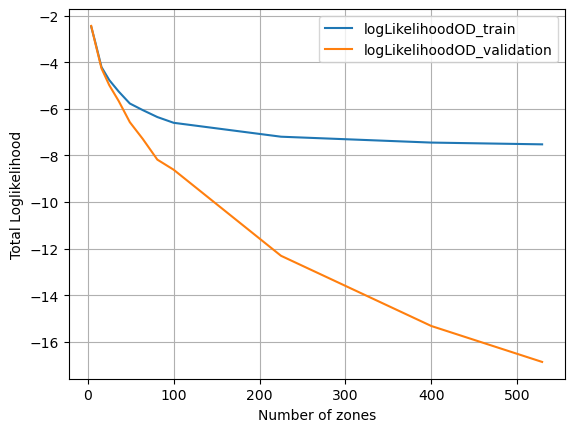

In [57]:
plt.plot(Number_zones_total_list,logLikelihoodOD_train_list, label='logLikelihoodOD_train' )
plt.plot(Number_zones_total_list,logLikelihoodOD_validation_list, label='logLikelihoodOD_validation')
plt.xlabel("Number of zones")
plt.ylabel("Total Loglikelihood")
plt.legend()
plt.grid()
plt.show()